In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    model = EEGNet_IE_TS_Wrapper(DEVICE, classifier, input_dim[1]).to(DEVICE)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
#     train_func= eeg_grad_train
#     model.training_procedure(iteration=n_epochs,
#                                     train_dataloader=train_dataloader,
#                                      val_dataloader=val_dataloader,
#                                      print_cycle=2,
#                                      path=f"./dictionary/intermdiate_dicts",
#                                      loss_func=criterion,
#                                      optimiser=optimizer, #scheduler=scheduler,
#                                      train_func=train_func
#                                     )
#     if model.epoch == n_epochs+1:
#         EPOCH= n_epochs
#     else:
#         EPOCH= model.epoch
    
#     torch.save(model.state_dict(), 
#            os.path.join(
#                saved_dir, f"Userfold-{participants[i]}-EEGNet-Grad_TS-e{EPOCH}.pt"
#            )
#     )

#     pickle.dump( model.return_IE_grad(), 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Grad_TS-grad_all-e{EPOCH}.pkl", "wb") 
#                )    

# OR
    model.load_state_dict(
    torch.load(
        open(
            os.path.join(
                saved_dir, f"Userfold-{participants[i]}-EEGNet-Grad_TS-e{n_epochs}.pt"
            ), "rb"
        )
              )
    )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


107 20

c0_acc 0.963963963963964 , c1_acc 0.4 , b_acc 0.681981981981982
114 5

c0_acc 0.991304347826087 , c1_acc 0.09433962264150944 , b_acc 0.5428219852337982
113 8

c0_acc 0.9186991869918699 , c1_acc 0.1509433962264151 , b_acc 0.5348212916091425
127 5

c0_acc 0.9694656488549618 , c1_acc 0.08928571428571429 , b_acc 0.529375681570338
115 4

c0_acc 0.9829059829059829 , c1_acc 0.08163265306122448 , b_acc 0.5322693179836037
122 3

c0_acc 0.976 , c1_acc 0.06 , b_acc 0.518
113 15

c0_acc 0.904 , c1_acc 0.26785714285714285 , b_acc 0.5859285714285715
123 1

c0_acc 0.9761904761904762 , c1_acc 0.01694915254237288 , b_acc 0.4965698143664245
130 7

c0_acc 0.9774436090225563 , c1_acc 0.12727272727272726 , b_acc 0.5523581681476418
125 7

c0_acc 0.9689922480620154 , c1_acc 0.11864406779661017 , b_acc 0.5438181579293128
118 6

c0_acc 0.9915966386554622 , c1_acc 0.125 , b_acc 0.5582983193277311
119 22

c0_acc 0.9754098360655737 , c1_acc 0.4074074074074074 , b_acc 0.6914086217364905
121 13

c0_acc 0.98

     accuracy  f1-score
S01  0.788820  0.762791
S02  0.708333  0.616905
S03  0.687500  0.629937
S04  0.705882  0.621916
S05  0.716867  0.628164
S06  0.714286  0.623421
S07  0.707182  0.671246
S08  0.670270  0.555877
S09  0.728723  0.654446
S10  0.702128  0.623363
S11  0.742515  0.665462
S12  0.801136  0.775198
S13  0.748603  0.693974
S14  0.707182  0.617302
S15  0.699454  0.621140
S16  0.704918  0.606075
S17  0.753012  0.712086
S19  0.668478  0.566320
S20  0.738889  0.662151


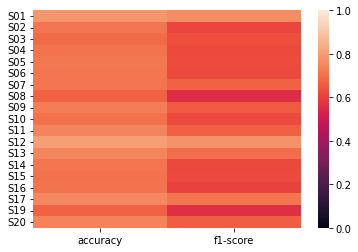

     class0 f1-score  class1 f1-score
S01         0.862903         0.540541
S02         0.823105         0.169492
S03         0.804270         0.225352
S04         0.822006         0.153846
S05         0.830325         0.145455
S06         0.829932         0.107143
S07         0.810036         0.361446
S08         0.801303         0.031746
S09         0.836013         0.215385
S10         0.816993         0.200000
S11         0.845878         0.218182
S12         0.871795         0.556962
S13         0.843206         0.366197
S14         0.822742         0.158730
S15         0.816054         0.179104
S16         0.823529         0.100000
S17         0.844106         0.405797
S19         0.798680         0.061538
S20         0.841751         0.253968


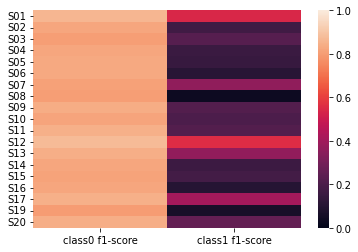

In [8]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [9]:
model.return_IE_weights()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)

In [6]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [38]:
from sklearn.preprocessing import MinMaxScaler
import pickle

participant_grad={"AUC":[],"ROC":[],"STD":[]}

for i in range(len(participants)):

    g= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Grad_TS-grad_all-e{n_epochs}.pkl", "rb") 
                    ) 
    
    participant_grad["AUC"].append(
        pd.DataFrame(
            Grad_AUC_with_grad(
                g, n_epochs, np.zeros(len(timestep_labels)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )
    
    participant_grad["ROC"].append(
        pd.DataFrame(
            Grad_ROC_with_grad(
                g, n_epochs, np.zeros(len(timestep_labels)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )
    
    participant_grad["STD"].append(
        pd.DataFrame(
            Grad_STD_with_grad(
                g, n_epochs, np.zeros(len(timestep_labels)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )

    
# avg_grad= np.array(participants_grad_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

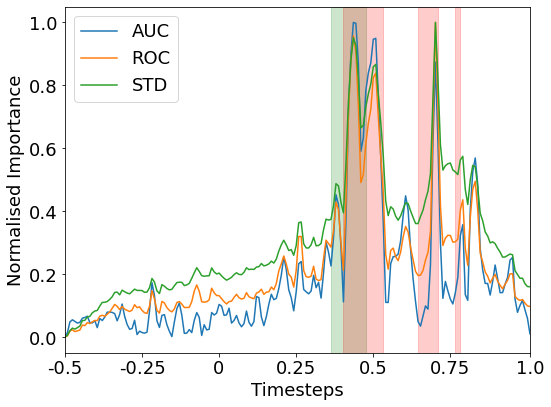

In [41]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
plt.figure(figsize=(8,6))
methods=["AUC", "ROC", "STD"]
for i in methods:
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(np.array(participant_grad[i]).mean(0).reshape(-1,1))
#     df.index= channel_names
#     df.columns=timestep_labels
    
#     scaled= scaler.fit_transform(df.sum().to_numpy().reshape(-1,1))
    plt.plot(scaled_avg_grad)
plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()